In [1]:
from Player import Player
from Trainer import Trainer
from TetrisModel import TetrisModel
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob

In [2]:
piece_dim = 8
key_dim = 12
depth = 32
gamma = 0.9

In [3]:
move_dict = {
    '0': 11,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 5,
    '7': 6,
    '8': 7,
    '9': 8,
    '10': 9,
    '11': 10,
}

In [4]:
players_data = [[], []]
for file in glob.glob('C:\\Users\\micha\\Downloads\\MisaMino-Tetrio-copy\\MisaMino-Tetrio-master\\tetris_ai\\logs\\game_att*.txt'):
    with open(file) as f:
        contents = f.readlines()
        for line in contents:
            players_data[int(line[0])].append(line[2:])
len(players_data[0]), len(players_data[1]) 

(390163, 390163)

In [5]:
def get_return_list(rewards, gamma):
    returns = []
    
    rewards = rewards[::-1]
    discounted_sum = 0
    
    for reward in rewards:
        discounted_sum = reward + gamma * discounted_sum
        returns.append(discounted_sum)
        
    returns = returns[::-1]
    return returns

In [6]:
dset_pieces = []
dset_boards = []
dset_actions = []
dset_attacks = []

for player_data in players_data:
    episode_pieces = []
    episode_boards = []
    episode_actions = []
    episode_attacks = []

    for i, line in enumerate(player_data[:-1]):
        current, hold, queue, raw_board, raw_action, total_att = line.strip().split('#')
        _, _, _, _, _, next_att = player_data[i+1].strip().split('#')
        
        piece_seq = [int(current)] + [int(hold)] + [int(piece) for piece in queue.split(',')[:5]]
        board = [[float(bit) for bit in '{:032b}'.format(int(row))[-10:][::-1]] for row in raw_board.split(',')[1:-4]]
        action = [move_dict[move_char] for move_char in raw_action.split(',')[:-1]]
        attack = int(next_att) - int(total_att)
        
        if len(action) > 0 and attack >= 0:
            action = [11] * (action[0] != 11) + action
        else:
            episode_attacks = get_return_list(episode_attacks, gamma)
    
            dset_pieces += episode_pieces
            dset_boards += episode_boards
            dset_actions += episode_actions
            dset_attacks += episode_attacks
            
            episode_pieces = []
            episode_boards = []
            episode_actions = []
            episode_attacks = []
            
            continue
    
        episode_pieces.append(piece_seq)
        episode_boards.append(board)
        episode_actions.append(action)
        episode_attacks.append(attack)

        if i % 10000 == 0:
            print(f'\r{(i+1)/len(player_data[:-1]):1.2f}', end='', flush=True)

1.00

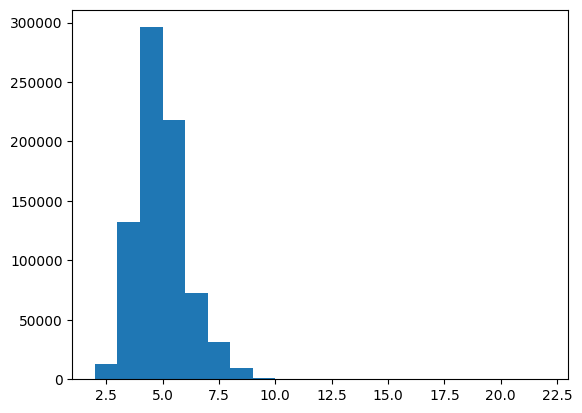

In [7]:
lengths = []
keys = [0] * key_dim
for action in dset_actions:
    lengths.append(len(action))
    for key in action:
        keys[key] += 1
max_len = max(lengths)
hist = plt.hist(lengths, bins=max(lengths)-min(lengths))

<BarContainer object of 12 artists>

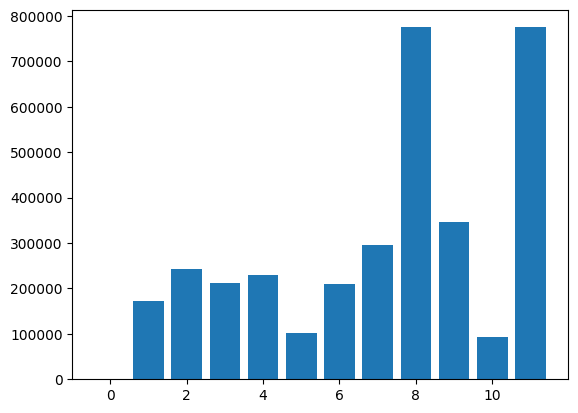

In [8]:
plt.bar(range(key_dim), keys)

In [9]:
def generator():
    for sample in zip(dset_pieces, dset_boards, dset_actions, dset_attacks):
        yield sample

In [10]:
def pad(item, length, pad_value=0):
    num_valid = tf.shape(item)[0]
    if num_valid > length:
        padded = item[:length]
    else:
        padded = tf.concat([item, tf.zeros((length - num_valid), dtype=item.dtype) + pad_value], axis=0)
    return padded

In [11]:
def pad_and_split(piece, board, action, att):
    padded_action = pad(action, max_len)
    inp = tf.ensure_shape(padded_action[:-1], (max_len-1,))
    tar = tf.ensure_shape(padded_action[1:], (max_len-1,))
    return (board, piece, inp), (tar, att)

In [12]:
gt_dset = (tf.data.Dataset.from_generator(generator,
                                          output_signature=(tf.TensorSpec(shape=(7,), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(28, 10), dtype=tf.float32),
                                                            tf.TensorSpec(shape=(None,), dtype=tf.int32),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))
           .map(pad_and_split,
                num_parallel_calls=tf.data.AUTOTUNE,
                deterministic=False)
           .cache()
           .shuffle(100000)
           .batch(128,
                  num_parallel_calls=tf.data.AUTOTUNE,
                  deterministic=False,
                  drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))
gt_dset

<PrefetchDataset element_spec=((TensorSpec(shape=(128, 28, 10), dtype=tf.float32, name=None), TensorSpec(shape=(128, 7), dtype=tf.float32, name=None), TensorSpec(shape=(128, 21), dtype=tf.int32, name=None)), (TensorSpec(shape=(128, 21), dtype=tf.int32, name=None), TensorSpec(shape=(128,), dtype=tf.float32, name=None)))>

In [13]:
# for i, ((board, piece, inp), (tar, att)) in enumerate(gt_dset):
#     print(f'\r{i}', end='', flush=True)

In [14]:
agent = TetrisModel(piece_dim=piece_dim,
                    key_dim=key_dim,
                    depth=depth,
                    num_heads=4,
                    num_layers=4,
                    max_length=max_len)

In [15]:
logits, values = agent((tf.random.uniform((1, 28, 10, 1)),
                        tf.random.uniform((1, 7), minval=0, maxval=8, dtype=tf.int32),
                        tf.random.uniform((1, max_len-1), minval=0, maxval=key_dim, dtype=tf.int32)))
agent.summary(), tf.shape(logits), tf.shape(values)

Model: "tetris_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 70, 32)               18816     
                                                                 
 seq_embedding (SeqEmbedding  multiple                 256       
 )                                                               
                                                                 
 seq_embedding_1 (SeqEmbeddi  multiple                 384       
 ng)                                                             
                                                                 
 pdec_0 (DecoderLayer)       multiple                  37984     
                                                                 
 pdec_1 (DecoderLayer)       multiple                  37984     
                                                                 
 pdec_2 (DecoderLayer)       multiple                 

(None,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 1, 21, 12])>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1])>)

In [16]:
scc = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
mse = keras.losses.MeanSquaredError(reduction='none')

In [17]:
@tf.function
def masked_logit_loss(true, pred, mask):
    raw_loss = scc(true, pred)
    
    loss = tf.reduce_sum(raw_loss * mask) / tf.reduce_sum(mask)
    return loss

In [18]:
@tf.function
def value_loss(true, pred):
    raw_loss = mse(true, pred)
    
    loss = tf.reduce_sum(raw_loss) / tf.cast(tf.shape(true)[0], tf.float32)
    return loss

In [19]:
@tf.function
def masked_logit_acc(true, pred, mask):
    preds = tf.argmax(pred, axis=-1, output_type=tf.int32)
    true = tf.cast(true, tf.int32)
    
    raw_acc = tf.cast(preds == true, tf.float32)
    
    acc = tf.reduce_sum(raw_acc * mask) / tf.reduce_sum(mask)
    return acc

In [20]:
agent_optimizer = keras.optimizers.Adam()
actor_optimizer = keras.optimizers.Adam()
critic_optimizer = keras.optimizers.Adam()

In [21]:
epochs = 20

In [22]:
@tf.function
def train_step(board, piece, inp, tar, att):
    mask = tf.cast(tar != 0, tf.float32)
    with tf.GradientTape() as tape:
        logits, values = agent((board, piece, inp), training=True)
        actor_loss = masked_logit_loss(tar, logits, mask)
        critic_loss = value_loss(att, values)
        loss = actor_loss + critic_loss
    grads = tape.gradient(loss, agent.trainable_variables)
    agent_optimizer.apply_gradients(zip(grads, agent.trainable_variables))
    
    acc = masked_logit_acc(tar, logits, mask)
    return loss, acc

In [23]:
losses, accs = [], []

In [ ]:
for epoch in range(epochs):
    print()
    last_time = time.time()
    for i, ((board, piece, inp), (tar, att)) in enumerate(gt_dset):
        loss, acc = train_step(board, piece, inp, tar, att)
        if i % 10 == 0:
            cur_time = time.time()
            print(f'\r{i}\t|\tLoss: {loss:1.2f}\t|\tAccuracy: {acc:1.2f}\t|\tStep Time: {(cur_time - last_time) * 100:3.0f}ms\t|\t', end='', flush=True)
            last_time = cur_time
            losses.append(loss)
            accs.append(acc)

In [ ]:
plt.plot(losses)
plt.plot(accs)

In [24]:
agent.load_weights('agent_weights/agent_finetuned')

In [ ]:
if 'y' in input('YOU SURE?????'):
    agent.save_weights('agent_weights/agent_finetuned')

In [25]:
%matplotlib qt

In [26]:
trainer = Trainer(model=agent,
                  optimizers=(actor_optimizer, critic_optimizer),
                  seq_len=max_len,
                  gamma=gamma,
                  max_episode_steps=1000)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: michaelsherrick. Use `wandb login --relogin` to force relogin


In [27]:
trainer.fill_replay_buffer()

NameError: name 'gamma' is not defined